**This project is build a semantic segmentation using oxford dataset.**<br>
[Coursera](https://www.coursera.org/projects/semantic-segmentation-sagemaker)
[Github](https://github.com/FarruhShahidi/Machine-Learning-with-AWS)

Let's install Libraries

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [4]:
import os
import json
import random
import tarfile
import urllib
import shutil
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


**Download and extract the data** <br>
[Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [5]:
urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')


**Data Visualization**

In [7]:
trimaps_dir = "data/annotations/trimaps/"
maps = [x for x in os.listdir(trimaps_dir) if x [-3:]=='png']
print(f'Total Annotation images:',len(maps))


image_dir = "data/images"
images = [x for x in os.listdir(image_dir) if x[-3:] =='jpg']
print(f'Total Images:',len(images))


Total Annotation images: 14780
Total Images: 7390


> In the annotation folder, there are total 14780 images and the number of orginal images is 7390. So we need to take same mapped images from annotations folder.

In [11]:
print(f'The name of any image is ->',(images[1]))

The name of any image is -> scottish_terrier_142.jpg


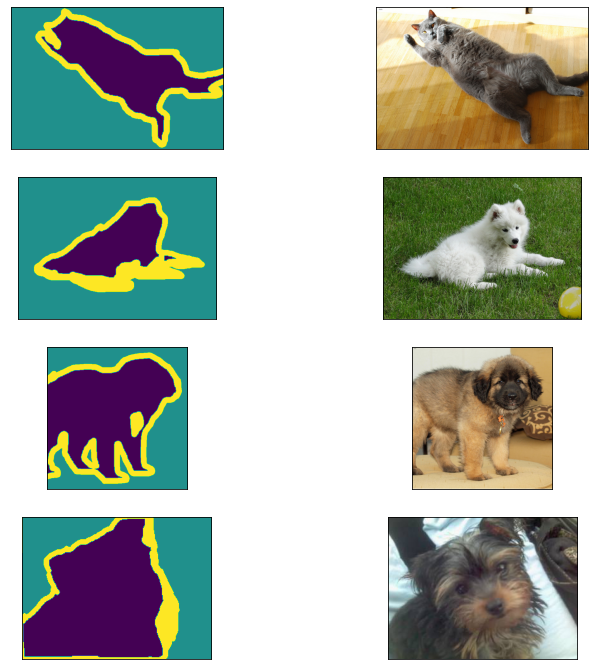

In [18]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index] # get the image numebr
    map_name = images[index].split('.')[0] + '.png' #Get the image name

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [21]:
img = Image.open(os.path.join(trimaps_dir, maps[1]))
print(np.unique(img))

[1 2 3]


**SAGEMAKER**

In [32]:
# get_image_uri() https://sagemaker.readthedocs.io/en/stable/v2.html
#Assign a role
role = sagemaker.get_execution_role()
bucket_name = 'semantic-imagespets'
training_image = get_image_uri(boto3.Session().region_name,'semantic-segmentation', repo_version = 'latest')
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


433757028032.dkr.ecr.us-west-2.amazonaws.com/semantic-segmentation:1


In [26]:
# Create seperated folder for training, validation
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)


**Data Preparation**

In [28]:
# Mapping function
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file

for image in tqdm(images):
    target_set = 'train' if random.randint(0,99)<75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)
    

100%|██████████| 7390/7390 [00:09<00:00, 754.65it/s] 


In [29]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [30]:
print(len(train_annots), len(train_images))

5529 5529


**Upload Data into S3**

In [33]:
%%time
sess = sagemaker.Session()

print('Starting upload..')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name,
                                     key_prefix='train_annotation')
print('Training Annotations uploaded')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name,
                                      key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name,
                                          key_prefix='validation_annotation')
print('Validation Annotations uploaded')

Starting upload..
Training images uploaded
Training Annotations uploaded
Validation images uploaded
Validation Annotations uploaded
CPU times: user 1min 23s, sys: 7.32 s, total: 1min 30s
Wall time: 13min 19s


In [34]:
# Let's print the path on s3 
print(s3_validation_annotation_path)

s3://semantic-imagespets/validation_annotation


**SageMaker Estimator**

In [47]:
model = sagemaker.estimator.Estimator(
    training_image,
    role = role,
    instance_count = 1,
    instance_type = 'ml.t3.medium',
    volume_size=100,
    max_run=36000,
    input_mode='File',
    output_path='s3://semantic-imagespets/output',
    sagemaker_session=sess
)

**Hyperparameter Tuning**

In [41]:
model.set_hyperparameters(
    backbone='resnet-50', # This is the encoder. Other option is resnet-50
    algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
    use_pretrained_model='True', # Use the pre-trained model.
    crop_size=240, # Size of image random crop.                             
    num_classes=4, # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10, # Number of epochs to run.
    learning_rate=0.0001,                             
    optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
    mini_batch_size=16, # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=3, # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
    num_training_samples=len(train_images)
)

**Data Channels**

In [42]:
train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.inputs.TrainingInput(s3_train_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.inputs.TrainingInput(s3_validation_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')

In [43]:
data_channels = {
    'train': train_data,
    'train_annotation': train_annotation_data,
    'validation': validation_data,
    'validation_annotation': validation_annotation_data
}

In [48]:
model.fit(inputs = data_channels, logs = True)

ClientError: An error occurred (ValidationException) when calling the CreateTrainingJob operation: 1 validation error detected: Value 'ml.t3.medium' at 'resourceConfig.instanceType' failed to satisfy constraint: Member must satisfy enum value set: [ml.p2.xlarge, ml.m5.4xlarge, ml.m4.16xlarge, ml.p4d.24xlarge, ml.g5.2xlarge, ml.c5n.xlarge, ml.p3.16xlarge, ml.m5.large, ml.p2.16xlarge, ml.g5.4xlarge, ml.c4.2xlarge, ml.c5.2xlarge, ml.c4.4xlarge, ml.g5.8xlarge, ml.c5.4xlarge, ml.c5n.18xlarge, ml.g4dn.xlarge, ml.g4dn.12xlarge, ml.c4.8xlarge, ml.g4dn.2xlarge, ml.c5.9xlarge, ml.g4dn.4xlarge, ml.c5.xlarge, ml.g4dn.16xlarge, ml.c4.xlarge, ml.g4dn.8xlarge, ml.g5.xlarge, ml.c5n.2xlarge, ml.g5.12xlarge, ml.g5.24xlarge, ml.c5n.4xlarge, ml.c5.18xlarge, ml.p3dn.24xlarge, ml.g5.48xlarge, ml.g5.16xlarge, ml.p3.2xlarge, ml.m5.xlarge, ml.m4.10xlarge, ml.c5n.9xlarge, ml.m5.12xlarge, ml.m4.xlarge, ml.m5.24xlarge, ml.m4.2xlarge, ml.p2.8xlarge, ml.m5.2xlarge, ml.p3.8xlarge, ml.m4.4xlarge]

**Lets test some images**

In [49]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1861


In [50]:
import io
mask = np.array(Image.open(io.BytesIO(results)))

NameError: name 'results' is not defined

In [51]:
plt.imshow(plt.imread(image_path));

NameError: name 'image_path' is not defined

In [52]:
plt.imshow(mask);

NameError: name 'mask' is not defined

***END***